# Chapter 5

## Exercise 5

### (a)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.formula.api as smf 

In [2]:
np.random.seed(1)
Default=load_data("Default")

In [3]:
Default.default

0       No
1       No
2       No
3       No
4       No
        ..
9995    No
9996    No
9997    No
9998    No
9999    No
Name: default, Length: 10000, dtype: object

In [4]:
allvars = Default.columns.drop(['default','student'])
design=MS(allvars)
X=design.fit_transform(Default)
y=Default.default=='Yes'
glm=sm.GLM(y,X,family=sm.families.Binomial())
res=glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Mon, 11 Sep 2023   Deviance:                       1579.0
Time:                        18:10:52   Pearson chi2:                 6.95e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1256
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================
"""

### (b)

#### (i) 

In [5]:
Default_train, Default_valid = train_test_split(Default, test_size=5000, random_state=0)
Default_valid

,default,student,balance,income
9394,No,Yes,0.000000,13911.441282
898,No,No,396.985985,55454.631040
2398,No,No,1046.416673,47598.307369
5906,No,No,836.343137,34559.158405
2343,No,Yes,534.692907,18729.566240
...,...,...,...,...
3996,No,No,794.176213,43335.985041
5889,No,No,81.531865,40847.811311
4577,No,No,1137.791157,21103.429621
8600,No,No,646.081240,36686.959447


#### (ii) 

In [6]:
allvars_train = Default_train.columns.drop(['default','student'])
design_train=MS(allvars_train)
X_train=design_train.fit_transform(Default_train)
y_train=Default_train.default=='Yes'
glm=sm.GLM(y_train,X_train,family=sm.families.Binomial())
res=glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -364.78
Date:                Mon, 11 Sep 2023   Deviance:                       729.56
Time:                        18:10:52   Pearson chi2:                 2.57e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1125
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.3896      0.635    -17.935      0.000     -12.634     -10.145
balance        0.0056      0.000     16.792      0.000       0.005       0.006
income       1.58e-05   7.34e-06      2.151      0.031     1.4e-06    3.02e-05
==============================================================================
"""

#### (iii)

In [7]:
X_valid=design_train.transform(Default_valid)
valid_pred = res.predict(X_valid)
labels=np.array(['No']*5000)
labels[valid_pred>0.5]='Yes'

#### (iv)

In [8]:
y_valid = Default_valid['default']
1-accuracy_score(y_valid, labels)

0.03979999999999995

## Exercise 6

### (a)

In [9]:
#We should add a column of dummy variables related to 'default' because without this manipulation
#GLM used hereafter won't succed in converting categorical variables into dummy ones.
Default['default_yes'] = (Default['default'] == 'Yes').astype('int')

In [10]:
allvars=Default.columns.drop(['default','student','default_yes'])
design=MS(allvars)
X=design.fit_transform(Default)
y=Default.default=='Yes'
model=sm.GLM(y,X,family=sm.families.Binomial())
result=model.fit()
summarize(result)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


In [11]:
result.bse#Generating the standard errors ofthe coefficients

intercept    0.434772
balance      0.000227
income       0.000005
dtype: float64

### (b)

In [12]:
def boot_SE(func,D,n=None,B=1000,seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,n,replace=True)
        value = func(D,idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)
def boot_fn(model_matrix,response,D,idx):
    D_=D.loc[idx]
    y=D_[response]
    X=clone(model_matrix).fit_transform(D_)
    model=sm.GLM(y,X,family=sm.families.Binomial())
    result=model.fit()
    coef_income=result.params[1]
    coef_balance=result.params[2]
    return result.params

### (c)

In [13]:
hp_func=partial(boot_fn,MS(['income','balance']),'default_yes')
#Below is a test for hp_func instantiation
rng = np.random.default_rng(0)
np.array([hp_func(Default,
          rng.choice(392,
                     392,
                     replace=True)) for _ in range(10)])

array([[-1.37418699e+01,  4.46108654e-05,  6.54456450e-03],
       [-9.73343593e+00,  1.29161125e-05,  4.36172555e-03],
       [-1.09652934e+01,  6.88991070e-06,  5.60127348e-03],
       [-1.29994735e+01,  5.80207964e-05,  5.99463447e-03],
       [-1.76482871e+01,  3.85717484e-05,  8.94706073e-03],
       [-1.37799054e+01,  7.20354708e-05,  5.64428958e-03],
       [-1.00286504e+01,  1.25804073e-05,  5.16837631e-03],
       [-1.36627122e+01,  3.52359713e-05,  6.88246994e-03],
       [-1.30954565e+01,  8.56134990e-06,  7.38734450e-03],
       [-1.41538872e+01,  3.45878793e-05,  7.22152035e-03]])

In [14]:
boot_SE(hp_func,Default,B=1000,seed=10)

intercept    0.425280
income       0.000005
balance      0.000227
dtype: float64

### (d)

Clearly we obtain approximate values by both methods.

## Exercise 7

### (a)

In [15]:
Weekly=load_data('Weekly')

In [16]:
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [17]:
Weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1089 non-null   int64  
 1   Lag1       1089 non-null   float64
 2   Lag2       1089 non-null   float64
 3   Lag3       1089 non-null   float64
 4   Lag4       1089 non-null   float64
 5   Lag5       1089 non-null   float64
 6   Volume     1089 non-null   float64
 7   Today      1089 non-null   float64
 8   Direction  1089 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB


In [18]:
#Fitting a logistic regression of Lag1 and Lag2 as exog and Direction as endog
allvars=Weekly.columns.drop(['Direction','Year','Volume','Today','Lag3','Lag4','Lag5'])
design=MS(allvars)
X=design.fit_transform(Weekly)
y=Weekly.Direction=='Up'
model=sm.GLM(y,X,family=sm.families.Binomial())
result=model.fit()
summarize(result)

,coef,std err,z,P>|z|
intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


### (b)

In [19]:
model_1=sm.GLM(y.iloc[1:],X.iloc[1:],family=sm.families.Binomial())
result_1=model_1.fit()
summarize(result_1)

,coef,std err,z,P>|z|
intercept,0.2232,0.061,3.630,0.000
Lag1,-0.0384,0.026,-1.466,0.143
Lag2,0.0608,0.027,2.291,0.022


### (c)

In [20]:
probs = result_1.predict([X.iloc[0]])
labels = np.array(['Down']*1)
labels[probs>0.5] = "Up"
labels

array(['Up'], dtype='<U4')

### (d)

In [21]:
n=len(Weekly)
errors=np.zeros(n)
for i in range(n):
    x_train=X.drop([i])
    y_train=y.drop([i])
    model_i=sm.GLM(y_train,x_train,family=sm.families.Binomial()).fit()
    x_test=X.iloc[i]
    pred=model_i.predict([x_test])
    labels = np.array(['Down']*1)
    labels[pred>0.5] = "Up"
    if labels[0]!=Weekly.Direction[i]:
        errors[i]=1

### (e)

In [22]:
errors.mean()

0.44995408631772266

The test error estimate is 45%. The logistic regression model performs poorly on average (It is slightly better than random guessing). This must be a consequence of the model not enough flexible relatively to the Bayes decision boundary.<br>
A possible remedy is to raise the power degrees of the predictors to increase flexibility.

## Exercise 8

### (a)

In [23]:
rng=np.random.default_rng(1)
x=rng.normal(size=100)
y=x-2*x**2+rng.normal(size=100)

n is the number of observations and p is the number of predictors. In this case there are two predictors which are $x$ and $x^2$.<br>
Hence, n=100 and p=2.

### (b)

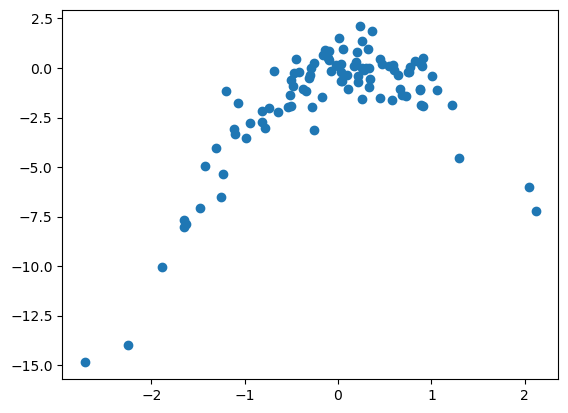

In [24]:
plt.scatter(x,y);

The scatter shows a quadratic plot. 
The two points in the bottom left corner could be outsiders.

### (c)

In [25]:
np.random.seed(7)

In [26]:
n=len(x)
x.reshape(1,-1)
y.reshape(1,-1)
cv_error = np.zeros(4)
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,5)):
    X = np.power.outer(x, np.arange(d+1))
    M_CV = cross_validate(M,X,y,cv=n)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

The model reported in ii returns the smallest CV error.

### (d)

In [27]:
np.random.seed(9)

In [28]:
cv_error2 = np.zeros(4)
x.reshape(1,-1)
y.reshape(1,-1)
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,5)):
    X = np.power.outer(x, np.arange(d+1))
    M_CV = cross_validate(M,X,y,cv=n)
    cv_error2[i] = np.mean(M_CV['test_score'])
cv_error2

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

The results are exactly the same because we only remove one observation from the training set. Thus, there is no random effect resulting from the observations used for the test set. LOOCV will always be the same, no matter the random seed is.

### (e)

The smallest error is found for the quadratic model ii. This result was expected since that model has the same form of the true one defined in question a.

### (f)

In [29]:
df=pd.DataFrame({'x':x,'y':y})
X= MS([poly('x', degree=4)],intercept=False).fit_transform(df)
model=sm.OLS(y,X)
result=model.fit()
summarize(result)

,coef,std err,t,P>|t|
"poly(x, degree=4)[0]",16.6000,1.911,8.685,0.000
"poly(x, degree=4)[1]",-22.2244,1.911,-11.627,0.000
"poly(x, degree=4)[2]",-1.0768,1.911,-0.563,0.575
"poly(x, degree=4)[3]",2.2726,1.911,1.189,0.237


As it was expected, the pvalues show that the only significant coefficients are those related to $x$ and $x^2$.

## Exercise 9

In [30]:
Boston=load_data('Boston')

### (a)

In [31]:
mu_hat=Boston['medv'].mean()
mu_hat

22.532806324110677

The population mean estimate for medv is 22.53.

### (b)

In [45]:
SE_mu_hat=Boston['medv'].std()/(Boston.shape[0])**0.5
SE_mu_hat

0.4088611474975351

The obtained estimation of the standard deviation is 0.41.

In [46]:
Boston['medv'].index

RangeIndex(start=0, stop=506, step=1)

### (c)

In [60]:
means=[]
for _ in range(1000):
    means.append(Boston['medv'].sample(n=Boston.shape[0],replace=True,random_state=None).mean())
boot_std=np.std(means)
boot_std

0.4047759328720298

The answer is approximately the same as the one obtained in (b).

### (d)

In [61]:
print('The 95% confidence interval for the mean of medv is', mu_hat-2*boot_std,mu_hat+2*boot_std)

The 95% confidence interval for the mean of medv is 21.72325445836662 23.342358189854735


### (e)

In [63]:
mu_med=Boston['medv'].median()
mu_med

21.2

### (f)

In [82]:
medians=[]
for _ in range(10000):
    medians.append(Boston['medv'].sample(n=Boston.shape[0],replace=True).median())
boot_med_std=np.std(medians)
boot_med_std

0.3806817673267263

The standard error of the median is less than the standard error of the mean. This a sign of non normality of the distribution of feature 'medv'.

In [85]:
mu_01=np.percentile(Boston['medv'],10)
mu_01

12.75

### (g)

In [88]:
percentiles=[]
for _ in range(5000):
    sample=Boston['medv'].sample(n=Boston.shape[0],replace=True)
    percentiles.append(np.percentile(sample,10))
boot_mu01_std=np.std(percentiles)
boot_mu01_std

0.500366615593007

The standard error is small relatively to the tenth percentile value.